In [58]:
!pip install lightgbm
!pip install shap
!pip install seaborn matplotlib


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [59]:
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
# Specify the file path (use the same path for input and output, just change the extension)

cnv_data = pd.read_csv("brca_tcga_data_CNA.csv", index_col = "Hugo_Symbol")
print("Data loaded successfully!")
print(f"Shape of the CNV data: {cnv_data.shape}")
display(cnv_data)

Data loaded successfully!
Shape of the CNV data: (25128, 1071)


,Entrez_Gene_Id,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
ACAP3,116983.0,0,-1,-1,0,0,0,-1,0,-1,...,0,-1,0,0,-1,-1,0,-1,-1,0
ACTRT2,140625.0,0,-1,-1,0,0,0,-1,0,-1,...,0,-1,0,0,-1,-1,0,-1,-1,0
AGRN,375790.0,0,-1,-1,0,0,0,-1,0,-1,...,0,-1,0,0,-1,-1,0,-1,-1,0
ANKRD65,441869.0,0,-1,-1,0,0,0,-1,0,-1,...,0,-1,0,0,-1,-1,0,-1,-1,0
ATAD3A,55210.0,0,-1,-1,0,0,0,-1,0,-1,...,0,-1,0,0,-1,-1,0,-1,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa-mir-513c,NaN,-1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,-1,0,1
hsa-mir-513b,NaN,-1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,-1,0,1
hsa-mir-513a-1,NaN,-1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,-1,0,1


In [61]:
# Drop the Entrez_Gene_Id column since it has some missing data and I know it will not be necessary for analysis/modelling
cnv_data_filtered = cnv_data.drop(columns=["Entrez_Gene_Id"])

# Save the cleaned data back to the same file
cnv_data_filtered.to_csv("cnv_data_filtered.csv")

print("Updated 'cnv_data_filtered.csv' saved without the 'Entrez_Gene_Id' column!")

Updated 'cnv_data_filtered.csv' saved without the 'Entrez_Gene_Id' column!


In [62]:
# Step 3: Combine CNV Categories
def combine_cnv_values(value):
    if value in [1, 2]:
        return 2  # Amplification
    elif value == 0:
        return 0  # Neutral
    elif value in [-1, -2]:
        return -2  # Deletion
    else:
        return value  # Catch any unexpected values

# Apply the combination function to each value
combined_cnv_data = cnv_data_filtered.applymap(combine_cnv_values)

print("Combination of CNV categories complete!")
print("First 5 rows of the combined data:")
print(combined_cnv_data.head())

Combination of CNV categories complete!
First 5 rows of the combined data:
             TCGA-3C-AAAU-01  TCGA-3C-AALI-01  TCGA-3C-AALJ-01  \
Hugo_Symbol                                                      
ACAP3                      0               -2               -2   
ACTRT2                     0               -2               -2   
AGRN                       0               -2               -2   
ANKRD65                    0               -2               -2   
ATAD3A                     0               -2               -2   

             TCGA-3C-AALK-01  TCGA-4H-AAAK-01  TCGA-5L-AAT0-01  \
Hugo_Symbol                                                      
ACAP3                      0                0                0   
ACTRT2                     0                0                0   
AGRN                       0                0                0   
ANKRD65                    0                0                0   
ATAD3A                     0                0                0   


In [63]:
# Step 4: Save the Processed Data
combined_cnv_data.to_csv('Processed_cnv_data.csv')

print("Processed data saved to 'processed_cnv_data.csv'")
print(f"Final shape of processed data: {combined_cnv_data.shape}")

Processed data saved to 'processed_cnv_data.csv'
Final shape of processed data: (25128, 1070)


In [64]:
# Collapse duplicates by selecting the max alteration profile per gene
combined_cnv_data_unique = combined_cnv_data.groupby(combined_cnv_data.index).max()

In [65]:

# Count CNV states per gene
cnv_counts = combined_cnv_data_unique.apply(lambda x: pd.Series({
    "Deletions": (x == -2).sum(),
    "Amplifications": (x == 2).sum(),
    "Neutral": (x == 0).sum(),
    "Total_Altered": (x != 0).sum()  # Total samples with any CNA
}), axis=1)

# Sort genes by total alterations (descending)
cnv_counts = cnv_counts.sort_values("Total_Altered", ascending=False)

In [66]:
# Save the full CNV frequency table (all genes)
cnv_counts.to_csv('CNA_frequency_per_gene.csv')
print("Saved: CNA_frequency_per_gene.csv")

Saved: CNA_frequency_per_gene.csv


In [67]:
# Sort by total alterations and display top 30
top_genes = cnv_counts.sort_values("Total_Altered", ascending=False).head(25)
print(top_genes[['Deletions', 'Amplifications', 'Total_Altered']])

             Deletions  Amplifications  Total_Altered
Hugo_Symbol                                          
FAM72C              30             829            859
SRGAP2D             33             826            859
MARCH2              11             821            832
MDM4                14             817            831
LRRN2               17             814            831
NFASC               18             813            831
PPP1R15B            15             815            830
LINC00628           15             815            830
PIK3C2B             13             817            830
PLEKHA6             16             814            830
GOLT1A              16             812            828
KISS1               16             812            828
LEMD1-AS1           15             812            827
REN                 15             812            827
RBBP5               17             810            827
CNTN2               17             810            827
LEMD1               16      

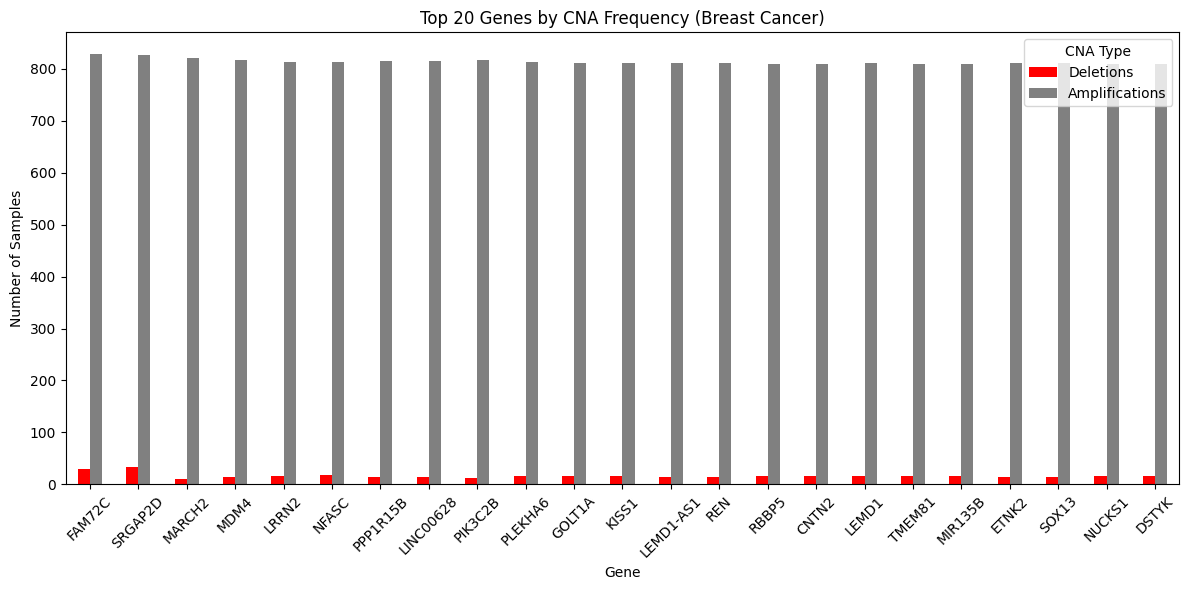

In [12]:
# Select top 25 genes
top_genes_25 = cnv_counts.head(25)

# Create stacked bar plot (excluding 'Neutral')
top_genes[["Deletions", "Amplifications"]].plot(
    kind="bar",
    stacked=False,
    color=["red", "grey"],
    figsize=(12, 6)
)

plt.title("Top 20 Genes by CNA Frequency (Breast Cancer)")
plt.xlabel("Gene")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.legend(title="CNA Type")
plt.tight_layout()
plt.show()

In [68]:
#Adding known genes
key_genes = [
    'ERBB2',  # HER2 amplifications (targetable)
    'TP53',   # Tumor suppressor (frequent in TNBC)
    'PTEN',   # PI3K pathway regulator
    'MYC',    # Oncogene (cell cycle)
    'CDH1',   # Metastasis suppressor
    'PIK3CA', # PI3K pathway
    'BRCA1',  # DNA repair (hereditary BC)
    'BRCA2',   # DNA repair
    'RB1',
    'CDKN2A',
    'FGFR1',
    'SLC6A10P',
]

In [69]:
key_gene_counts = cnv_counts.loc[cnv_counts.index.isin(key_genes)]
print("CNV Counts for Key Breast Cancer Genes:")
print(key_gene_counts[['Deletions', 'Amplifications', 'Total_Altered']])

CNV Counts for Key Breast Cancer Genes:
             Deletions  Amplifications  Total_Altered
Hugo_Symbol                                          
CDH1               663             102            765
SLC6A10P           353             389            742
TP53               650              54            704
MYC                 26             671            697
FGFR1              266             398            664
ERBB2              260             329            589
RB1                498              84            582
BRCA1              368             212            580
BRCA2              443             116            559
CDKN2A             361             145            506
PTEN               324              87            411
PIK3CA              58             332            390


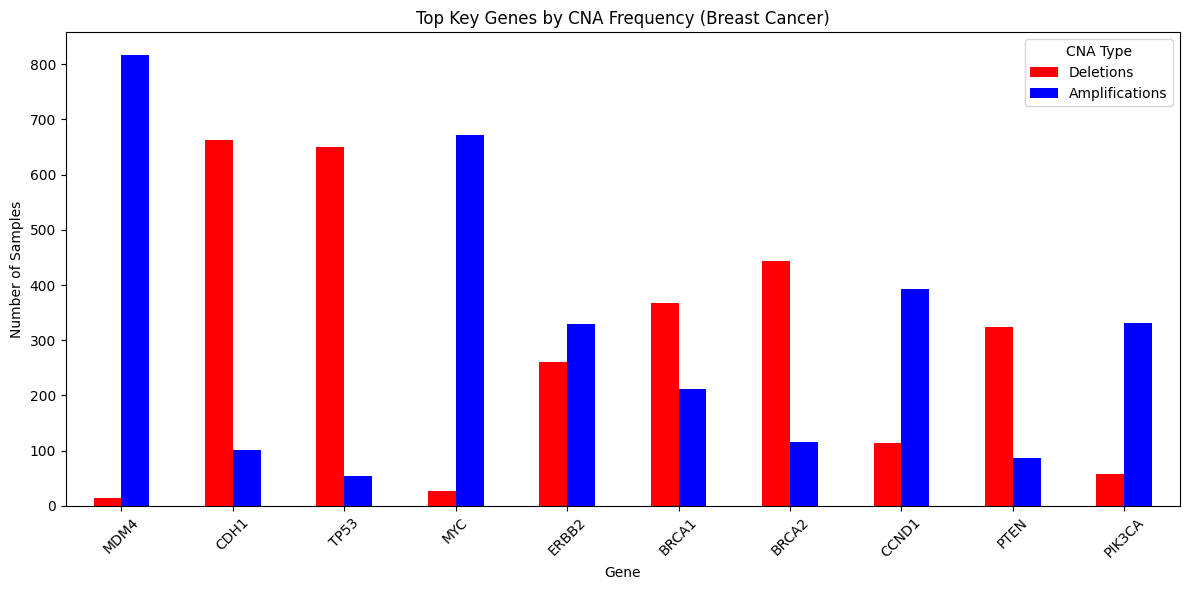

In [13]:
# Select top 10 genes
top_10_genes = key_gene_counts.head(10)

# Create stacked bar plot (excluding 'Neutral')
top_10_genes[["Deletions", "Amplifications"]].plot(
    kind="bar",
    stacked=False,
    color=["red", "blue"],
    figsize=(12, 6)
)

plt.title("Top Key Genes by CNA Frequency (Breast Cancer)")
plt.xlabel("Gene")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.legend(title="CNA Type")
plt.tight_layout()
plt.show()

In [70]:
# Make sure 'top_genes' only contains gene names
top_genes = cnv_counts.sort_values("Total_Altered", ascending=False).head(25).index.tolist()

# Filter out any non-genes accidentally in the list
top_genes = [gene for gene in top_genes if gene in combined_cnv_data.index]

# Now combine with key_genes (deduplicate the list)
combined_genes = list(dict.fromkeys(key_genes + top_genes))  # keeps order, removes duplicates

# Final filtering
filtered_cnv_data = combined_cnv_data.loc[
    combined_cnv_data.index.intersection(combined_genes)
]

# Deduplicate genes in the filtered dataframe itself — in case some genes exist more than once in combined_cnv_data
filtered_cnv_data = filtered_cnv_data.groupby(filtered_cnv_data.index).max()

print(f" Selected {len(filtered_cnv_data)} unique genes for ML modeling:")
print(filtered_cnv_data.index.tolist())
print("\nFiltered CNV data shape:", filtered_cnv_data.shape)

# Save the cleaned data
filtered_cnv_data.to_csv('filtered_ml_genes_cnv.csv')

✅ Selected 37 unique genes for ML modeling:
['BRCA1', 'BRCA2', 'CDH1', 'CDK18', 'CDKN2A', 'CNTN2', 'DSTYK', 'ERBB2', 'ETNK2', 'FAM72C', 'FGFR1', 'GOLT1A', 'KISS1', 'KLHDC8A', 'LEMD1', 'LEMD1-AS1', 'LINC00628', 'LRRN2', 'MARCH2', 'MDM4', 'MIR135B', 'MYC', 'NFASC', 'NUCKS1', 'PIK3C2B', 'PIK3CA', 'PLEKHA6', 'PPP1R15B', 'PTEN', 'RB1', 'RBBP5', 'REN', 'SLC6A10P', 'SOX13', 'SRGAP2D', 'TMEM81', 'TP53']

Filtered CNV data shape: (37, 1070)


In [71]:
# Now I have to load the methylation data, so I can continue to model training.

# Load the imputed methylation data
methylation_data = pd.read_csv("data_methylation_imputed.csv", index_col="GENE_POSITION")

# Inspect the dataset
print(methylation_data.head())

                           TCGA-3C-AAAU-01  TCGA-3C-AALI-01  TCGA-3C-AALJ-01  \
GENE_POSITION                                                                  
ATP2A1_1stExon                    0.678483         0.261045         0.850628   
MEOX2_1stExon                     0.100005         0.044714         0.496529   
HOXD3_5'UTR                       0.875122         0.680860         0.774736   
PANX1_1stExon                     0.028658         0.027581         0.032019   
KIAA1409;COX8C_Body;5'UTR         0.954225         0.933860         0.941596   

                           TCGA-3C-AALK-01  TCGA-4H-AAAK-01  TCGA-5L-AAT0-01  \
GENE_POSITION                                                                  
ATP2A1_1stExon                    0.733004         0.796488         0.411649   
MEOX2_1stExon                     0.272595         0.116450         0.251992   
HOXD3_5'UTR                       0.626697         0.638573         0.635766   
PANX1_1stExon                     0.024

In [72]:
# Extract the common samples (intersection of methylation and CNV data sample IDs)
common_samples = set(methylation_data.columns) & set(filtered_cnv_data.columns)

# Subset methylation and CNV data using the common sample IDs
methylation_subset = methylation_data.loc[:, methylation_data.columns.isin(common_samples)]
cnv_subset = filtered_cnv_data.loc[:, filtered_cnv_data.columns.isin(common_samples)]

# Verify that the extracted subsets still contain the expected sample count
print(f"Methylation subset sample count: {methylation_subset.shape[1]}")
print(f"CNV subset sample count: {cnv_subset.shape[1]}")

# Check for any IDs lost after extraction
lost_in_methylation = common_samples - set(methylation_subset.columns)
lost_in_cnv = common_samples - set(cnv_subset.columns)

print(f"Sample IDs lost after extraction in methylation: {lost_in_methylation}")
print(f"Sample IDs lost after extraction in CNV: {lost_in_cnv}")

Methylation subset sample count: 1053
CNV subset sample count: 1053
Sample IDs lost after extraction in methylation: set()
Sample IDs lost after extraction in CNV: set()


In [73]:
# Transpose the filtered data
transposed_cnv_data = cnv_subset.T
transposed_methylation_data = methylation_subset.T

print("Transposed CNV data shape:", transposed_cnv_data.shape)
print("Transposed Methylation data shape:", transposed_methylation_data.shape)
#print("First 5 rows of transposed CNV data:")
#print(transposed_cnv_data.head())
#print("First 5 rows of transposed Methylation data:")
#print(transposed_methylation_data.head())

Transposed CNV data shape: (1053, 37)
Transposed Methylation data shape: (1053, 22601)


In [33]:
np.random.seed(42)  # Fix any random elements

In [74]:
from collections import Counter
import warnings
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import shap
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Label Preprocessing
def preprocess_gene_labels(y, min_samples=100):
    y = pd.Series(y)
    counts = Counter(y)
    valid_classes = [cls for cls in counts if counts[cls] >= min_samples]
    mask = y.isin(valid_classes)
    y_filtered = y[mask]
    if len(set(y_filtered)) <= 1:
        print(f"  ⚠️ Too few valid classes after filtering: {Counter(y_filtered)}. Skipping.")
        return None, None
    return y_filtered.index, y_filtered

# Model Setup
models = {
    'RandomForest': RandomForestClassifier(n_estimators=300, max_depth=25, min_samples_split=5, random_state=42, max_features=0.5, n_jobs=-1, class_weight='balanced_subsample'),
    'LGBMClassifier': LGBMClassifier(n_estimators=2000, max_depth=-1, subsample=0.8, min_child_samples=20, random_state=42, verbose=-1, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, max_depth=7, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', random_state=42),
    'LogisticRegression': LogisticRegression(penalty='elasticnet', solver='saga', max_iter=5000, random_state=42, C=0.1, l1_ratio=0.5, class_weight='balanced', n_jobs=-1),
    'DecisionTree': DecisionTreeClassifier(max_depth=None, min_samples_split=10, min_samples_leaf=5, class_weight='balanced', random_state=42)
}

# === NEW TRACKING STRUCTURES ===
shap_dict = {}
features_dict = {}
model_dict = {}
auc_dict = {}
roc_auc_results = {}

# Training Loop
for gene in transposed_cnv_data.columns:
    print(f"\n Training models for: {gene}")
    y_raw = transposed_cnv_data[gene]
    sample_idx, y = preprocess_gene_labels(y_raw, min_samples=100)
    if y is None:
        continue

    X = transposed_methylation_data.loc[sample_idx]
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    stratify_param = y_encoded if all(count >= 2 for count in Counter(y_encoded).values()) else None
    X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=stratify_param)

    selector = SelectKBest(score_func=mutual_info_classif, k=min(1000, X_train.shape[1]))
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)

    n_classes = len(np.unique(y_train))
    xgb_params = {
        'use_label_encoder': False,
        'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
        'random_state': 42,
        'n_estimators': 300,
        'max_depth': 6,
        'min_child_weight':3,
        'learning_rate': 0.2,
        'objective': 'multi:softprob' if n_classes > 2 else 'binary:logistic'
    }
    models['XGBClassifier'] = XGBClassifier(**xgb_params)

    best_score = -np.inf
    best_model = None
    best_model_name = None
    roc_auc_results[gene] = {}

    for name, model in models.items():
        try:
            model.fit(X_train_selected, y_train)
            y_proba = model.predict_proba(X_val_selected)
            y_pred = model.predict(X_val_selected)
            roc_auc = roc_auc_score(y_val, y_proba, multi_class='ovr') if n_classes > 2 else roc_auc_score(y_val, y_proba[:, 1])
            roc_auc_results[gene][name] = roc_auc
            print(f"  {name:>20} → Accuracy: {accuracy_score(y_val, y_pred):.3f}, ROC AUC: {roc_auc:.3f}")
            if roc_auc > best_score:
                best_score = roc_auc
                best_model = model
                best_model_name = name
        except Exception as e:
            print(f"  ❌ {name} failed: {str(e)}")

    if best_model is None:
        print(f"  ⚠️ No model trained successfully for {gene}. Skipping.")
        continue

    print(f"\n✅ Best model for {gene}: {best_model_name} (AUC = {best_score:.3f})")
    print(classification_report(label_encoder.inverse_transform(y_val), label_encoder.inverse_transform(best_model.predict(X_val_selected)), zero_division=0))
    print(confusion_matrix(label_encoder.inverse_transform(y_val), label_encoder.inverse_transform(best_model.predict(X_val_selected))))

    # Save best model
    model_dict[gene] = best_model
    auc_dict[gene] = best_score

    pipeline = Pipeline([
        ('selector', SelectKBest(score_func=mutual_info_classif, k=min(1000, X.shape[1]))),
        ('classifier', best_model)
    ])
    try:
        cv_scores = cross_val_score(pipeline, X, y_encoded, cv=StratifiedKFold(n_splits=5), scoring='roc_auc_ovr')
        print(f"   📊 Cross-Validation AUC: {np.mean(cv_scores):.3f} (±{np.std(cv_scores):.3f})")
    except Exception as e:
        print(f"   ⚠️ Cross-validation failed: {e}")

    # SHAP
    try:
        selected_features = X.columns[selector.get_support()]
        explainer = shap.Explainer(best_model, X_val_selected, feature_names=selected_features)
        shap_values = explainer(X_val_selected)

        shap_dict[gene] = shap_values
        features_dict[gene] = selected_features
    except Exception as e:
        print(f"⚠️ SHAP failed for {gene}: {e}")



 Training models for: BRCA1
          RandomForest → Accuracy: 0.720, ROC AUC: 0.837
        LGBMClassifier → Accuracy: 0.777, ROC AUC: 0.857
      GradientBoosting → Accuracy: 0.744, ROC AUC: 0.837
    LogisticRegression → Accuracy: 0.664, ROC AUC: 0.805
          DecisionTree → Accuracy: 0.583, ROC AUC: 0.709
         XGBClassifier → Accuracy: 0.739, ROC AUC: 0.853

✅ Best model for BRCA1: LGBMClassifier (AUC = 0.857)
              precision    recall  f1-score   support

          -2       0.82      0.85      0.84        72
           0       0.76      0.83      0.80        96
           2       0.72      0.53      0.61        43

    accuracy                           0.78       211
   macro avg       0.77      0.74      0.75       211
weighted avg       0.77      0.78      0.77       211

[[61  9  2]
 [ 9 80  7]
 [ 4 16 23]]
   📊 Cross-Validation AUC: 0.877 (±0.022)


 97%|=================== | 617/633 [00:27<00:00]       


 Training models for: BRCA2
          RandomForest → Accuracy: 0.678, ROC AUC: 0.807
        LGBMClassifier → Accuracy: 0.744, ROC AUC: 0.828
      GradientBoosting → Accuracy: 0.725, ROC AUC: 0.816
    LogisticRegression → Accuracy: 0.573, ROC AUC: 0.719
          DecisionTree → Accuracy: 0.602, ROC AUC: 0.664
         XGBClassifier → Accuracy: 0.725, ROC AUC: 0.833

✅ Best model for BRCA2: XGBClassifier (AUC = 0.833)
              precision    recall  f1-score   support

          -2       0.76      0.74      0.75        87
           0       0.70      0.82      0.76       101
           2       0.67      0.26      0.38        23

    accuracy                           0.73       211
   macro avg       0.71      0.61      0.63       211
weighted avg       0.72      0.73      0.71       211

[[64 23  0]
 [15 83  3]
 [ 5 12  6]]
   📊 Cross-Validation AUC: 0.828 (±0.042)

 Training models for: CDH1
          RandomForest → Accuracy: 0.768, ROC AUC: 0.849
        LGBMClassifier → Accura

 98%|===================| 619/633 [00:16<00:00]        


 Training models for: CNTN2
          RandomForest → Accuracy: 0.808, ROC AUC: 0.852
        LGBMClassifier → Accuracy: 0.846, ROC AUC: 0.919
      GradientBoosting → Accuracy: 0.808, ROC AUC: 0.891
    LogisticRegression → Accuracy: 0.745, ROC AUC: 0.851
          DecisionTree → Accuracy: 0.731, ROC AUC: 0.665
         XGBClassifier → Accuracy: 0.837, ROC AUC: 0.897

✅ Best model for CNTN2: LGBMClassifier (AUC = 0.919)
              precision    recall  f1-score   support

           0       0.83      0.42      0.56        48
           2       0.85      0.97      0.91       160

    accuracy                           0.85       208
   macro avg       0.84      0.70      0.73       208
weighted avg       0.84      0.85      0.83       208

[[ 20  28]
 [  4 156]]
   📊 Cross-Validation AUC: 0.906 (±0.021)

 Training models for: DSTYK
          RandomForest → Accuracy: 0.817, ROC AUC: 0.867
        LGBMClassifier → Accuracy: 0.832, ROC AUC: 0.903
      GradientBoosting → Accuracy: 0.812

 93%|=================== | 190/205 [00:13<00:01]       


 Training models for: FGFR1
          RandomForest → Accuracy: 0.697, ROC AUC: 0.861
        LGBMClassifier → Accuracy: 0.730, ROC AUC: 0.884
      GradientBoosting → Accuracy: 0.706, ROC AUC: 0.845
    LogisticRegression → Accuracy: 0.573, ROC AUC: 0.762
          DecisionTree → Accuracy: 0.578, ROC AUC: 0.710
         XGBClassifier → Accuracy: 0.720, ROC AUC: 0.882

✅ Best model for FGFR1: LGBMClassifier (AUC = 0.884)
              precision    recall  f1-score   support

          -2       0.75      0.79      0.77        53
           0       0.68      0.72      0.70        80
           2       0.77      0.69      0.73        78

    accuracy                           0.73       211
   macro avg       0.73      0.74      0.73       211
weighted avg       0.73      0.73      0.73       211

[[42  9  2]
 [ 8 58 14]
 [ 6 18 54]]
   📊 Cross-Validation AUC: 0.884 (±0.013)


100%|===================| 630/633 [00:27<00:00]        


 Training models for: GOLT1A
          RandomForest → Accuracy: 0.788, ROC AUC: 0.863
        LGBMClassifier → Accuracy: 0.846, ROC AUC: 0.911
      GradientBoosting → Accuracy: 0.779, ROC AUC: 0.872
    LogisticRegression → Accuracy: 0.712, ROC AUC: 0.825
          DecisionTree → Accuracy: 0.716, ROC AUC: 0.710
         XGBClassifier → Accuracy: 0.856, ROC AUC: 0.898

✅ Best model for GOLT1A: LGBMClassifier (AUC = 0.911)
              precision    recall  f1-score   support

           0       0.71      0.56      0.63        48
           2       0.88      0.93      0.90       160

    accuracy                           0.85       208
   macro avg       0.79      0.75      0.77       208
weighted avg       0.84      0.85      0.84       208

[[ 27  21]
 [ 11 149]]
   📊 Cross-Validation AUC: 0.906 (±0.018)

 Training models for: KISS1
          RandomForest → Accuracy: 0.788, ROC AUC: 0.863
        LGBMClassifier → Accuracy: 0.846, ROC AUC: 0.911
      GradientBoosting → Accuracy: 0.7

 97%|=================== | 612/633 [00:11<00:00]       


 Training models for: SOX13
          RandomForest → Accuracy: 0.817, ROC AUC: 0.858
        LGBMClassifier → Accuracy: 0.837, ROC AUC: 0.879
      GradientBoosting → Accuracy: 0.817, ROC AUC: 0.871
    LogisticRegression → Accuracy: 0.731, ROC AUC: 0.830
          DecisionTree → Accuracy: 0.731, ROC AUC: 0.703
         XGBClassifier → Accuracy: 0.846, ROC AUC: 0.884

✅ Best model for SOX13: XGBClassifier (AUC = 0.884)
              precision    recall  f1-score   support

           0       0.75      0.50      0.60        48
           2       0.86      0.95      0.90       160

    accuracy                           0.85       208
   macro avg       0.81      0.72      0.75       208
weighted avg       0.84      0.85      0.83       208

[[ 24  24]
 [  8 152]]
   📊 Cross-Validation AUC: 0.901 (±0.015)

 Training models for: SRGAP2D
          RandomForest → Accuracy: 0.853, ROC AUC: 0.858
        LGBMClassifier → Accuracy: 0.902, ROC AUC: 0.924
      GradientBoosting → Accuracy: 0.85

In [133]:
from collections import Counter
import warnings
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import shap
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Label preprocessing
def preprocess_gene_labels(y, min_samples=100):
    y = pd.Series(y)
    counts = Counter(y)
    valid_classes = [cls for cls in counts if counts[cls] >= min_samples]
    mask = y.isin(valid_classes)
    y_filtered = y[mask]
    if len(set(y_filtered)) <= 1:
        print(f"  ⚠️ Too few valid classes after filtering: {Counter(y_filtered)}. Skipping.")
        return None, None
    return y_filtered.index, y_filtered

# Define models
base_models = {
    'RandomForest': RandomForestClassifier(n_estimators=300, max_depth=25, min_samples_split=5, random_state=42, max_features=0.5, n_jobs=-1, class_weight='balanced_subsample'),
    'LGBMClassifier': LGBMClassifier(n_estimators=2000, max_depth=-1, subsample=0.8, min_child_samples=20, random_state=42, verbose=-1, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, max_depth=7, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', random_state=42),
    'LogisticRegression': LogisticRegression(penalty='elasticnet', solver='saga', max_iter=5000, random_state=42, C=0.1, l1_ratio=0.5, class_weight='balanced', n_jobs=-1),
    'DecisionTree': DecisionTreeClassifier(max_depth=None, min_samples_split=10, min_samples_leaf=5, class_weight='balanced', random_state=42)
}

# Dictionaries to store results
shap_dict = {}
features_dict = {}
model_dict = {}
auc_dict = {}
roc_auc_results = {}
val_data_dict = {}  # Store X_val_selected and y_val per gene
label_encoders = {}

# Training loop
for gene in transposed_cnv_data.columns:
    print(f"\nTraining models for: {gene}")
    y_raw = transposed_cnv_data[gene]
    sample_idx, y = preprocess_gene_labels(y_raw, min_samples=100)
    if y is None:
        continue

    X = transposed_methylation_data.loc[sample_idx]
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    label_encoders[gene] = label_encoder

    stratify_param = y_encoded if all(count >= 2 for count in Counter(y_encoded).values()) else None
    X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=stratify_param)

    selector = SelectKBest(score_func=mutual_info_classif, k=min(1000, X_train.shape[1]))
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)

    n_classes = len(np.unique(y_train))
    models = base_models.copy()
    models['XGBClassifier'] = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss' if n_classes == 2 else 'mlogloss',
        random_state=42,
        n_estimators=300,
        max_depth=6,
        min_child_weight=3,
        learning_rate=0.2,
        objective='multi:softprob' if n_classes > 2 else 'binary:logistic'
    )

    best_score = -np.inf
    best_model = None
    best_model_name = None
    roc_auc_results[gene] = {}

    for name, model in models.items():
        try:
            model.fit(X_train_selected, y_train)
            y_proba = model.predict_proba(X_val_selected)
            y_pred = model.predict(X_val_selected)
            roc_auc = roc_auc_score(y_val, y_proba, multi_class='ovr') if n_classes > 2 else roc_auc_score(y_val, y_proba[:, 1])
            roc_auc_results[gene][name] = roc_auc
            print(f"  {name:>20} → Accuracy: {accuracy_score(y_val, y_pred):.3f}, ROC AUC: {roc_auc:.3f}")
            if roc_auc > best_score:
                best_score = roc_auc
                best_model = model
                best_model_name = name
        except Exception as e:
            print(f"  ❌ {name} failed: {str(e)}")

    if best_model is None:
        print(f"  ⚠️ No model trained successfully for {gene}. Skipping.")
        continue

    print(f"\n✅ Best model for {gene}: {best_model_name} (AUC = {best_score:.3f})")
    print(classification_report(label_encoder.inverse_transform(y_val), label_encoder.inverse_transform(best_model.predict(X_val_selected)), zero_division=0))
    print(confusion_matrix(label_encoder.inverse_transform(y_val), label_encoder.inverse_transform(best_model.predict(X_val_selected))))

    model_dict[gene] = best_model
    auc_dict[gene] = best_score
    val_data_dict[gene] = {'X_val': X_val_selected, 'y_val': y_val}

    try:
        pipeline = Pipeline([
            ('selector', SelectKBest(score_func=mutual_info_classif, k=min(1000, X.shape[1]))),
            ('classifier', best_model)
        ])
        cv_scores = cross_val_score(pipeline, X, y_encoded, cv=StratifiedKFold(n_splits=5), scoring='roc_auc_ovr')
        print(f"   📊 Cross-Validation AUC: {np.mean(cv_scores):.3f} (±{np.std(cv_scores):.3f})")
    except Exception as e:
        print(f"   ⚠️ Cross-validation failed: {e}")

    # SHAP explanation
    try:
        selected_features = X.columns[selector.get_support()]
        explainer = shap.Explainer(best_model, X_val_selected, feature_names=selected_features)
        shap_values = explainer(X_val_selected)
        shap_dict[gene] = shap_values
        features_dict[gene] = selected_features
    except Exception as e:
        print(f"⚠️ SHAP failed for {gene}: {e}")



Training models for: BRCA1
          RandomForest → Accuracy: 0.720, ROC AUC: 0.837
        LGBMClassifier → Accuracy: 0.777, ROC AUC: 0.857
      GradientBoosting → Accuracy: 0.744, ROC AUC: 0.837
    LogisticRegression → Accuracy: 0.664, ROC AUC: 0.805
          DecisionTree → Accuracy: 0.583, ROC AUC: 0.709
         XGBClassifier → Accuracy: 0.739, ROC AUC: 0.853

✅ Best model for BRCA1: LGBMClassifier (AUC = 0.857)
              precision    recall  f1-score   support

          -2       0.82      0.85      0.84        72
           0       0.76      0.83      0.80        96
           2       0.72      0.53      0.61        43

    accuracy                           0.78       211
   macro avg       0.77      0.74      0.75       211
weighted avg       0.77      0.78      0.77       211

[[61  9  2]
 [ 9 80  7]
 [ 4 16 23]]
   📊 Cross-Validation AUC: 0.877 (±0.022)


 98%|===================| 621/633 [00:33<00:00]        


Training models for: BRCA2
          RandomForest → Accuracy: 0.678, ROC AUC: 0.807
        LGBMClassifier → Accuracy: 0.744, ROC AUC: 0.828
      GradientBoosting → Accuracy: 0.725, ROC AUC: 0.816
    LogisticRegression → Accuracy: 0.573, ROC AUC: 0.719
          DecisionTree → Accuracy: 0.602, ROC AUC: 0.664
         XGBClassifier → Accuracy: 0.725, ROC AUC: 0.833

✅ Best model for BRCA2: XGBClassifier (AUC = 0.833)
              precision    recall  f1-score   support

          -2       0.76      0.74      0.75        87
           0       0.70      0.82      0.76       101
           2       0.67      0.26      0.38        23

    accuracy                           0.73       211
   macro avg       0.71      0.61      0.63       211
weighted avg       0.72      0.73      0.71       211

[[64 23  0]
 [15 83  3]
 [ 5 12  6]]
   📊 Cross-Validation AUC: 0.828 (±0.042)

Training models for: CDH1
          RandomForest → Accuracy: 0.768, ROC AUC: 0.849
        LGBMClassifier → Accuracy

 99%|===================| 624/633 [00:17<00:00]        


Training models for: CNTN2
          RandomForest → Accuracy: 0.808, ROC AUC: 0.852
        LGBMClassifier → Accuracy: 0.846, ROC AUC: 0.919
      GradientBoosting → Accuracy: 0.808, ROC AUC: 0.891
    LogisticRegression → Accuracy: 0.745, ROC AUC: 0.851
          DecisionTree → Accuracy: 0.731, ROC AUC: 0.665
         XGBClassifier → Accuracy: 0.837, ROC AUC: 0.897

✅ Best model for CNTN2: LGBMClassifier (AUC = 0.919)
              precision    recall  f1-score   support

           0       0.83      0.42      0.56        48
           2       0.85      0.97      0.91       160

    accuracy                           0.85       208
   macro avg       0.84      0.70      0.73       208
weighted avg       0.84      0.85      0.83       208

[[ 20  28]
 [  4 156]]
   📊 Cross-Validation AUC: 0.906 (±0.021)

Training models for: DSTYK
          RandomForest → Accuracy: 0.817, ROC AUC: 0.867
        LGBMClassifier → Accuracy: 0.832, ROC AUC: 0.903
      GradientBoosting → Accuracy: 0.812, 

 95%|=================== | 195/205 [00:16<00:00]       


Training models for: FGFR1
          RandomForest → Accuracy: 0.697, ROC AUC: 0.861
        LGBMClassifier → Accuracy: 0.730, ROC AUC: 0.884
      GradientBoosting → Accuracy: 0.706, ROC AUC: 0.845
    LogisticRegression → Accuracy: 0.573, ROC AUC: 0.762
          DecisionTree → Accuracy: 0.578, ROC AUC: 0.710
         XGBClassifier → Accuracy: 0.720, ROC AUC: 0.882

✅ Best model for FGFR1: LGBMClassifier (AUC = 0.884)
              precision    recall  f1-score   support

          -2       0.75      0.79      0.77        53
           0       0.68      0.72      0.70        80
           2       0.77      0.69      0.73        78

    accuracy                           0.73       211
   macro avg       0.73      0.74      0.73       211
weighted avg       0.73      0.73      0.73       211

[[42  9  2]
 [ 8 58 14]
 [ 6 18 54]]
   📊 Cross-Validation AUC: 0.884 (±0.013)


 97%|=================== | 615/633 [00:31<00:00]       


Training models for: GOLT1A
          RandomForest → Accuracy: 0.788, ROC AUC: 0.863
        LGBMClassifier → Accuracy: 0.846, ROC AUC: 0.911
      GradientBoosting → Accuracy: 0.779, ROC AUC: 0.872
    LogisticRegression → Accuracy: 0.712, ROC AUC: 0.825
          DecisionTree → Accuracy: 0.716, ROC AUC: 0.710
         XGBClassifier → Accuracy: 0.856, ROC AUC: 0.898

✅ Best model for GOLT1A: LGBMClassifier (AUC = 0.911)
              precision    recall  f1-score   support

           0       0.71      0.56      0.63        48
           2       0.88      0.93      0.90       160

    accuracy                           0.85       208
   macro avg       0.79      0.75      0.77       208
weighted avg       0.84      0.85      0.84       208

[[ 27  21]
 [ 11 149]]
   📊 Cross-Validation AUC: 0.906 (±0.018)

Training models for: KISS1
          RandomForest → Accuracy: 0.788, ROC AUC: 0.863
        LGBMClassifier → Accuracy: 0.846, ROC AUC: 0.911
      GradientBoosting → Accuracy: 0.779

In [141]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, roc_auc_score
from sklearn.preprocessing import label_binarize

def plot_and_save_roc_curves(model_dict, val_data_dict, label_encoders, output_dir="roc_plots"):
    """
    Save ROC plots as PNG files for all genes (binary + multiclass) in a folder.
    
    Args:
        model_dict: Dictionary of trained models {gene: model}
        val_data_dict: Dictionary of validation data {gene: {'X_val': ..., 'y_val': ...}}
        label_encoders: Dictionary of label encoders {gene: LabelEncoder}
        output_dir: Folder to save PNG files
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    for gene in model_dict.keys():
        try:
            # Get data
            X_val = val_data_dict[gene]["X_val"]
            y_val = val_data_dict[gene]["y_val"]
            model = model_dict[gene]
            label_encoder = label_encoders[gene]
            
            # Check for class mismatches
            n_classes_encoder = len(label_encoder.classes_)
            y_proba = model.predict_proba(X_val)
            n_classes_proba = y_proba.shape[1]
            
            plt.figure(figsize=(8, 6))
            
            # Case 1: Binary classification
            if n_classes_proba == 2:
                roc_auc = roc_auc_score(y_val, y_proba[:, 1])
                RocCurveDisplay.from_predictions(
                    y_val,
                    y_proba[:, 1],
                    name=f"{gene} (AUC = {roc_auc:.2f})",
                    color="darkorange"
                )
                title = f"Binary ROC: {gene}"
                if n_classes_encoder != 2:
                    title += f"\n(Encoder has {n_classes_encoder} classes)"
            
            # Case 2: Multiclass classification
            else:
                n_plot_classes = min(n_classes_encoder, n_classes_proba)
                y_val_bin = label_binarize(y_val, classes=np.arange(n_classes_encoder))
                
                colors = plt.cm.rainbow(np.linspace(0, 1, n_plot_classes))
                for i in range(n_plot_classes):
                    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(
                        fpr,
                        tpr,
                        color=colors[i],
                        lw=2,
                        label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})"
                    )
                title = f"Multiclass ROC: {gene}"
                if n_classes_encoder != n_classes_proba:
                    title += f"\n(Encoder: {n_classes_encoder} vs Model: {n_classes_proba} classes)"
            
            # Common plot settings
            plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.5)")
            plt.title(title)
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")
            plt.grid(True)
            
            # Save as PNG
            output_path = os.path.join(output_dir, f"{gene}_roc.png")
            plt.savefig(output_path, bbox_inches='tight', dpi=300)
            plt.close()
            
        except Exception as e:
            print(f"⚠️ Failed to plot {gene}: {str(e)}")
            plt.close()

# Usage
plot_and_save_roc_curves(model_dict, val_data_dict, label_encoders, "roc_plots")
print(f"✅ Saved all ROC plots to 'roc_plots' folder")

⚠️ Failed to plot BRCA1: multi_class must be in ('ovo', 'ovr')
⚠️ Failed to plot CDH1: multi_class must be in ('ovo', 'ovr')
⚠️ Failed to plot CDKN2A: multi_class must be in ('ovo', 'ovr')
⚠️ Failed to plot FGFR1: multi_class must be in ('ovo', 'ovr')
✅ Saved all ROC plots to 'roc_plots' folder


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

PLOT ROC AUC CURVES FOR AL THE GENES

In [142]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, roc_auc_score
from sklearn.preprocessing import label_binarize

def plot_and_save_roc_curves(model_dict, val_data_dict, label_encoders, output_dir="roc_plots"):
    os.makedirs(output_dir, exist_ok=True)
    
    for gene in model_dict.keys():
        try:
            X_val = val_data_dict[gene]["X_val"]
            y_val = val_data_dict[gene]["y_val"]
            model = model_dict[gene]
            le = label_encoders[gene]
            n_classes = len(le.classes_)
            y_proba = model.predict_proba(X_val)
            
            plt.figure(figsize=(8, 6))
            
            # Case 1: Strict binary classification (encoder has exactly 2 classes)
            if n_classes == 2:
                if y_proba.shape[1] != 2:
                    raise ValueError(f"Model output shape {y_proba.shape[1]} doesn't match 2 classes")
                
                roc_auc = roc_auc_score(y_val, y_proba[:, 1])
                RocCurveDisplay.from_predictions(
                    y_val,
                    y_proba[:, 1],
                    name=f"{gene} (AUC = {roc_auc:.3f})",
                    color="darkorange"
                )
            
            # Case 2: Multiclass or binary-as-multiclass
            else:
                # Handle binary models pretending to be multiclass
                if y_proba.shape[1] == 2 and n_classes > 2:
                    print(f"⚠️ {gene}: Binary model for {n_classes}-class problem. Using first class.")
                    roc_auc = roc_auc_score(y_val, y_proba[:, 1])
                    RocCurveDisplay.from_predictions(
                        (y_val == 0).astype(int),  # Compare against first class
                        y_proba[:, 1],
                        name=f"{gene} (AUC = {roc_auc:.3f})",
                        color="darkblue"
                    )
                else:
                    # True multiclass
                    y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))
                    colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))
                    
                    for i in range(n_classes):
                        fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
                        roc_auc = auc(fpr, tpr)
                        plt.plot(
                            fpr,
                            tpr,
                            color=colors[i],
                            lw=2,
                            label=f"{le.classes_[i]} (AUC = {roc_auc:.3f})"
                        )
            
            plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.5)")
            plt.title(f"{gene} (Classes: {list(le.classes_)})")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")
            plt.grid(True)
            
            plt.savefig(os.path.join(output_dir, f"{gene}_roc.png"), bbox_inches='tight', dpi=300)
            plt.close()
            
        except Exception as e:
            print(f"⚠️ Failed to plot {gene}: {str(e)}")
            plt.close()

# Usage
plot_and_save_roc_curves(model_dict, val_data_dict, label_encoders)

⚠️ BRCA1: Binary model for 3-class problem. Using first class.
⚠️ Failed to plot BRCA1: multi_class must be in ('ovo', 'ovr')
⚠️ CDH1: Binary model for 3-class problem. Using first class.
⚠️ Failed to plot CDH1: multi_class must be in ('ovo', 'ovr')
⚠️ CDKN2A: Binary model for 3-class problem. Using first class.
⚠️ Failed to plot CDKN2A: multi_class must be in ('ovo', 'ovr')
⚠️ FGFR1: Binary model for 3-class problem. Using first class.
⚠️ Failed to plot FGFR1: multi_class must be in ('ovo', 'ovr')


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [110]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import shap

# Setup output directory
os.makedirs("shap_plots", exist_ok=True)

# === CNV Label Mapping ===
CNV_LABEL_MAP = {
    0: -2,  # Model class 0 → Deletion
    1: 0,   # Model class 1 → Neutral
    2: 2    # Model class 2 → Amplification
}

def get_cnv_label(class_idx):
    """Map model class index to descriptive biological label"""
    cnv_val = CNV_LABEL_MAP.get(class_idx, class_idx)
    if cnv_val == -2:
        return "Deletion (CNV=-2)"
    elif cnv_val == 0:
        return "Neutral (CNV=0)"
    elif cnv_val == 2:
        return "Amplification (CNV=2)"
    return f"Class {class_idx}"

def get_binary_class_label(model, gene):
    """Get biologically meaningful label for binary classification cases"""
    classes = model.classes_
    if len(classes) != 2:
        return f"{gene} - SHAP Values"
    
    # Determine which class is the "event" class (either -2 or 2)
    event_class = classes[0] if abs(classes[0]) > abs(classes[1]) else classes[1]
    
    if event_class == -2:
        return f"{gene} - Deletion (CNV=-2) Features"
    elif event_class == 2:
        return f"{gene} - Amplification (CNV=2) Features"
    else:
        return f"{gene} - CNV={event_class} Features"

def plot_shap_for_gene(gene, shap_values, val_data, selected_features):
    """Generate SHAP plots for one gene with proper CNV labels"""
    # Convert Explanation object to numpy array
    shap_array = shap_values.values if hasattr(shap_values, 'values') else np.array(shap_values)
    model = model_dict[gene]  # Get the trained model for this gene

    # === 1. Global Feature Importance (Bar Plot) ===
    plt.figure(figsize=(10, 6))
    if len(shap_array.shape) == 2:
        # Binary classification
        shap.summary_plot(
            shap_array,
            val_data,
            plot_type="bar",
            max_display=10,
            show=False
        )
        plt.title(f"{gene} - Global Feature Importance")
    else:
        # Multiclass classification
        try:
            class_names = [get_cnv_label(i) for i in range(shap_array.shape[2])]
            shap.summary_plot(
                shap_array,
                val_data,
                plot_type="bar",
                max_display=10,
                show=False,
                class_names=class_names
            )
        except TypeError:
            shap.summary_plot(
                shap_array,
                val_data,
                plot_type="bar",
                max_display=10,
                show=False
            )
        plt.title(f"{gene} - Global Feature Importance")

    plt.savefig(f"shap_plots/{gene}_global.png", bbox_inches='tight', dpi=150)
    plt.close()

    # === 2. Beeswarm Plots ===
    if len(shap_array.shape) == 2:
        # Binary case
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            shap_array,
            val_data,
            max_display=10,
            show=False
        )
        plt.title(get_binary_class_label(model, gene))  # Use the new function for proper labeling
        plt.savefig(f"shap_plots/{gene}_beeswarm.png", bbox_inches='tight', dpi=150)
        plt.close()
    else:
        # Multiclass: separate beeswarm for each class
        for class_idx in range(shap_array.shape[2]):
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_array[:, :, class_idx],
                val_data,
                max_display=10,
                show=False
            )
            plt.title(f"{gene} - {get_cnv_label(class_idx)} Features")
            plt.savefig(
                f"shap_plots/{gene}_CNV{CNV_LABEL_MAP[class_idx]}_beeswarm.png",
                bbox_inches='tight', dpi=150
            )
            plt.close()

# === Main Loop ===
for gene in tqdm(shap_dict.keys(), desc="Generating SHAP plots"):
    try:
        shap_explanation = shap_dict[gene]

        # Recover or reconstruct validation data
        if hasattr(shap_explanation, 'data'):
            val_data = pd.DataFrame(
                shap_explanation.data,
                columns=features_dict.get(gene, [f"F{i}" for i in range(shap_explanation.data.shape[1])])
            )
        else:
            # Fallback: create dummy features if data not available
            n_samples = shap_explanation.values[0].shape[0]
            n_features = len(features_dict.get(gene, []))
            val_data = pd.DataFrame(
                np.zeros((n_samples, n_features)),
                columns=features_dict.get(gene, [f"F{i}" for i in range(n_features)])
            )

        # Plot
        plot_shap_for_gene(
            gene=gene,
            shap_values=shap_explanation,
            val_data=val_data,
            selected_features=features_dict.get(gene, [])
        )

    except Exception as e:
        print(f"\n⚠️ Error processing {gene}: {str(e)}")
        continue

print("\n✅ SHAP visualization complete!")

Generating SHAP plots: 100%|███████████████████████████████████████████████████████████| 36/36 [00:33<00:00,  1.09it/s]


✅ SHAP visualization complete!


In [145]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import shap

# Setup output directory
os.makedirs("shap_plots", exist_ok=True)

# === CNV Label Mapping ===
CNV_LABEL_MAP = {
    0: -2,  # Model class 0 → Deletion
    1: 0,   # Model class 1 → Neutral
    2: 2    # Model class 2 → Amplification
}

def get_cnv_label(class_idx):
    """Map model class index to descriptive biological label"""
    cnv_val = CNV_LABEL_MAP.get(class_idx, class_idx)
    if cnv_val == -2:
        return "Deletion (CNV=-2)"
    elif cnv_val == 0:
        return "Neutral (CNV=0)"
    elif cnv_val == 2:
        return "Amplification (CNV=2)"
    return f"Class {class_idx}"

def get_binary_plot_title(gene, model):
    """Get correct title for binary case based on model's classes"""
    classes = model.classes_
    if -2 in classes:
        return f"{gene} - Deletion (CNV=-2) Features"
    elif 2 in classes:
        return f"{gene} - Amplification (CNV=2) Features"
    return f"{gene} - SHAP Values"

def plot_shap_for_gene(gene, shap_values, val_data, selected_features):
    """Generate SHAP plots for one gene with proper CNV labels"""
    # Convert Explanation object to numpy array
    shap_array = shap_values.values if hasattr(shap_values, 'values') else np.array(shap_values)
    model = model_dict[gene]  # Get the trained model for this gene

    # === 1. Global Feature Importance (Bar Plot) ===
    plt.figure(figsize=(10, 6))
    if len(shap_array.shape) == 2:
        # Binary classification
        shap.summary_plot(
            shap_array,
            val_data,
            plot_type="bar",
            max_display=10,
            show=False
        )
        plt.title(f"{gene} - Global Feature Importance")
    else:
        # Multiclass classification
        try:
            class_names = [get_cnv_label(i) for i in range(shap_array.shape[2])]
            shap.summary_plot(
                shap_array,
                val_data,
                plot_type="bar",
                max_display=10,
                show=False,
                class_names=class_names
            )
        except TypeError:
            shap.summary_plot(
                shap_array,
                val_data,
                plot_type="bar",
                max_display=10,
                show=False
            )
        plt.title(f"{gene} - Global Feature Importance")

    plt.savefig(f"shap_plots/{gene}_global.png", bbox_inches='tight', dpi=150)
    plt.close()

    # === 2. Beeswarm Plots ===
    if len(shap_array.shape) == 2:
        # Binary case
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            shap_array,
            val_data,
            max_display=10,
            show=False
        )
        plt.title(get_binary_plot_title(gene, model))  # Use the correct title function
        plt.savefig(f"shap_plots/{gene}_beeswarm.png", bbox_inches='tight', dpi=150)
        plt.close()
    else:
        # Multiclass: separate beeswarm for each class
        for class_idx in range(shap_array.shape[2]):
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_array[:, :, class_idx],
                val_data,
                max_display=10,
                show=False
            )
            plt.title(f"{gene} - {get_cnv_label(class_idx)} Features")
            plt.savefig(
                f"shap_plots/{gene}_CNV{CNV_LABEL_MAP[class_idx]}_beeswarm.png",
                bbox_inches='tight', dpi=150
            )
            plt.close()

# === Main Loop ===
for gene in tqdm(shap_dict.keys(), desc="Generating SHAP plots"):
    try:
        shap_explanation = shap_dict[gene]

        # Recover or reconstruct validation data
        if hasattr(shap_explanation, 'data'):
            val_data = pd.DataFrame(
                shap_explanation.data,
                columns=features_dict.get(gene, [f"F{i}" for i in range(shap_explanation.data.shape[1])])
            )
        else:
            # Fallback: create dummy features if data not available
            n_samples = shap_explanation.values[0].shape[0]
            n_features = len(features_dict.get(gene, []))
            val_data = pd.DataFrame(
                np.zeros((n_samples, n_features)),
                columns=features_dict.get(gene, [f"F{i}" for i in range(n_features)])
            )

        # Plot
        plot_shap_for_gene(
            gene=gene,
            shap_values=shap_explanation,
            val_data=val_data,
            selected_features=features_dict.get(gene, [])
        )

    except Exception as e:
        print(f"\n⚠️ Error processing {gene}: {str(e)}")
        continue

print("\n✅ SHAP visualization complete!")

Generating SHAP plots: 100%|███████████████████████████████████████████████████████████| 36/36 [00:31<00:00,  1.14it/s]


✅ SHAP visualization complete!
